# 01. Vary types of the Artificial Neural Network

<img src = https://imgur.com/s4HMZ3V.png width = 700>



<img src = https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/PyTorch_logo_black.svg/120px-PyTorch_logo_black.svg.png width = 150>

[PyTorch](https://en.wikipedia.org/wiki/PyTorch) is a machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, originally developed by Meta AI and now part of the Linux Foundation umbrella.  

It is free and open-source software released under the modified BSD license.  

Although the Python interface is more polished and the primary focus of development, PyTorch also has a C++ interface.

[Installation Guide](https://pytorch.org/get-started/previous-versions/)

In [1]:
import os
from tqdm import tqdm
import pandas as pds
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sbn

import torchvision
import torch
import pytorch_lightning as pl
import torchmetrics

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
training_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
)

test_data = torchvision.datasets.MNIST(
    root=".",
    train=False,
    download=True,
)

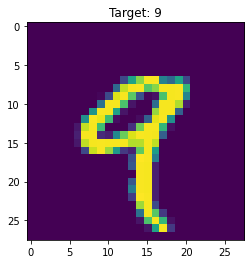

In [4]:
img, target = training_data[4]
plt.imshow(img)
plt.title('Target: ' + str(target))
plt.show()

## 01-01. Pytorch dataloader

Pytorch dataloader는 batch 단위의 데이터를 torch의 data type으로 관리하는 것을 도와주는 클래스입니다. 

먼저, torch dataset을 활용하여 인덱스를 입력하면 데이터를 불러오는 오브젝트를 생성합니다. 

그리고 생성한 dataset 오브젝트를 torch dataloader에 전달해주면, 매 학습 epoch마다 지정된 batch size의 데이터를 불러오도록 도와줍니다. 

In [5]:
training_data.data[:10].max(),training_data.data[:10].min() 

(tensor(255, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

In [6]:
training_data.data[0].shape

torch.Size([28, 28])

In [7]:
# 데이터 셋 클래스의 목표는 하나입니다. 
# 파이토치 학습 프레임워크에서 데이터에 존재할 수 있는 특정 인덱스를 호출했을 때, 인덱스에 해당하는 데이터들을 리턴하는 것 입니다. 
# 불러온 데이터들은 모델의 입출력에 맞는 데이터를 불러와야 합니다. 

# DNN 코드에서 일부분 수정되었습니다. 

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, data, training = True):
        super().__init__()
        
        self._X = data.data.unsqueeze(1)
        self._training = training
        
        if self._training:
            self._Y = data.targets

        self._X = self.transforms(self._X)
            
    @staticmethod
    def transforms(x):
        return x / 255
    
            
    def __len__(self):
        return len(self._X)
    
    
    def __getitem__(self, idx):
        if self._training:
            return self._X[idx], self._Y[idx]
        else:
            return self._X[idx]

# Pytorch lightning은 pytorch 과정에서 항상 똑같이 반복되는 코드들을 사용자가 작성하지 않도록 도와줌으로써 피로도를 감소시킵니다. 
# Pytorch lightning datamodule 클래스를 활용하여, torch dataloader가 lightning에서 사용할 수 있도록 호환시킬 수 있습니다.

        
class pl_datamodule(pl.LightningDataModule):
    def __init__(self, train, valid, batch_size = 64):
        super().__init__()
        self._train = train
        self._valid = valid
        self._batch_size = batch_size
        
                     
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = custom_dataset(self._train)
            self.valid_dataset = custom_dataset(self._valid)

        elif stage == "test" or stage is None:
            pass
                     
                     
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size = self._batch_size, shuffle = True, num_workers = 12)
                     
        
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size = self._batch_size, shuffle = False, num_workers = 12)

## 01-02. Pytorch Model

아래 이미지를 처리하는 모델에는 이전 코드와 두가지 다른 layer가 활용됩니다. 

    1. Convolution layer
    2. Maxpooling layer
    
    

<img src = https://imgur.com/27Ovfzt.png width = 600>

<center><b> 1. Convolution Layer </b></center>

<img src = https://imgur.com/mmEw8c0.png width = 600>
<center><b> 2. Maxpooling Layer </b></center>

In [8]:
class pl_model(pl.LightningModule):
    def __init__(self, dims, lr = 1e-3, device = None):
        super().__init__()
            
        self.input_dims = dims[:-1]
        self.output_dims = dims[1:]
        self.dims_flag = [False] * (len(self.input_dims) - 1) + [True]
        self._lr = lr
        
        self.build_model()
        
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        self.acc_fn = torchmetrics.Accuracy(num_classes = dims[-1])
        self.auc_fn = torchmetrics.AUROC(num_classes = dims[-1])
        self.f1_fn = torchmetrics.F1Score(num_classes = dims[-1], average = 'macro')
        
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self._lr)

    
    def build_block(self, i, o, output_flag = False):
        if output_flag:
            return torch.nn.Sequential(
                torch.nn.Flatten(),
                torch.nn.Linear(i,o),
            )
        else:
            return torch.nn.Sequential(
                torch.nn.Conv2d(i, o, kernel_size = 3, padding = 'same'),
                torch.nn.MaxPool2d(kernel_size = 2),
#                 torch.nn.BatchNorm1d(o),
                torch.nn.ReLU(),
#                 torch.nn.Dropout(),
            )
    
    
    def build_model(self):
        nets = []
        for i,o,f in zip(self.input_dims, self.output_dims, self.dims_flag):
            print(i,o,f)
            nets.append(self.build_block(i,o,f))
        self.net = torch.nn.ModuleList(nets)

        
    def forward(self, x):
        for l in self.net:
            x = l(x)
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        acc = self.acc_fn(y_hat, y)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        auc = self.auc_fn(y_hat, y)
        self.log('train_auc', auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        f1 = self.f1_fn(y_hat, y)
        self.log('train_f1_macro', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        loss = self.loss_fn(y_hat, y)
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        acc = self.acc_fn(y_hat, y)
        self.log('valid_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        auc = self.auc_fn(y_hat, y)
        self.log('valid_auc', auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        f1 = self.f1_fn(y_hat, y)
        self.log('valid_f1_macro', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    
    def predict_step(self, batch, batch_idx):
        return self.extract_feature(batch[0])
        
    
    def extract_feature(self, x):
        feature_list = []
        for l in self.net:
            x = l(x)
            feature_list.append(x)
        return feature_list[-1], feature_list

## 02-01. Training

In [9]:
dims = [1,8,8,8,8,10]
dims

[1, 8, 8, 8, 8, 10]

In [10]:
DM = pl_datamodule(training_data, test_data, 512)
DM.setup('fit')

In [13]:
model = pl_model(dims)

trainer = pl.Trainer(
    # accelerator='gpu', 
    # devices=[0],
    max_epochs=10,
)

model.train()
trainer.fit(model, DM)

1 8 False
8 8 False
8 8 False
8 8 False
8 10 True


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | net     | ModuleList       | 1.9 K 
1 | loss_fn | CrossEntropyLoss | 0     
2 | acc_fn  | Accuracy         | 0     
3 | auc_fn  | AUROC            | 0     
4 | f1_fn   | F1Score          | 0     
---------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\keb20\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: DataLoader worker (pid(s) 2600, 18832, 3308, 16188, 9568, 21468, 15840, 20192, 21808, 24416, 18120, 8752) exited unexpectedly

## 02-02. Summary to the performance of the model

In [ ]:
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
from glob import glob

numb_logs = len(glob(os.path.join('.','lightning_logs','*'))) - 1

log_path = glob(os.path.join('.','lightning_logs', f'version_{numb_logs}', 'events*'))[0]

load_logs = EventFileLoader(log_path)

load_logs = [i for i in load_logs.Load()]

def tag_parser(log):
    try:
        tag = log.summary.value[0].tag
        value = log.summary.value[0].tensor.float_val[0]
        return tag, value
    except:
        return None

logger = dict()
for log in load_logs[1:]:
    key, value = tag_parser(log)
    if key not in logger.keys():
        logger[key] = [value]
    else:
        logger[key].append(value)
else:
    logger['epoch'] = logger['epoch'][::2]


In [ ]:
fig,ax = plt.subplots(4,1,figsize = (10, 6), sharex = True)
ax[0].plot(logger['epoch'], logger['train_loss'])
ax[0].plot(logger['epoch'], logger['valid_loss'])
argmin_loss = np.argmin(logger['valid_loss'])
ax[0].plot(argmin_loss, logger['valid_loss'][argmin_loss],'xr')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train','Validation'])

ax[1].plot(logger['epoch'], logger['train_acc'])
ax[1].plot(logger['epoch'], logger['valid_acc'])
argmax_acc = np.argmax(logger['valid_acc'])
ax[1].plot(argmax_acc, logger['valid_acc'][argmax_acc],'xr')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Train','Validation'])

ax[2].plot(logger['epoch'], logger['train_auc'])
ax[2].plot(logger['epoch'], logger['valid_auc'])
argmax_auc = np.argmax(logger['valid_auc'])
ax[2].plot(argmax_auc, logger['valid_auc'][argmax_auc],'xr')
ax[2].set_ylabel('AUROC')
ax[2].set_xlabel('Epochs')
ax[2].legend(['Train','Validation'])

ax[3].plot(logger['epoch'], logger['train_f1_macro'])
ax[3].plot(logger['epoch'], logger['valid_f1_macro'])
argmax_f1_macro = np.argmax(logger['valid_f1_macro'])
ax[3].plot(argmax_f1_macro, logger['valid_f1_macro'][argmax_f1_macro],'xr')
ax[3].set_ylabel('F1 macro')
ax[3].set_xlabel('Epochs')
ax[3].legend(['Train','Validation'])

fig.tight_layout()
fig.show()

## 02-03. Illustrate to the extratec feature maps by each layer

In [ ]:
model.eval()
for bidx, b in enumerate(DM.val_dataloader()):
    with torch.no_grad():
        logits, features = model.predict_step(b, bidx)
    break

In [ ]:
[i.shape for i in features]

In [ ]:
sample_number = 101

plt.rcParams['font.size'] = 15

fig, axes = plt.subplots(3, 8, figsize = (32, 12))
for nl, (ax, flist) in enumerate(zip(axes, features), 1):
    for n, col_ax in enumerate(ax):
        col_ax.imshow(flist[sample_number, n])
        if n == 0:
            col_ax.set_ylabel(f'Conv Layer Number: {nl}')
            
fig.tight_layout()
            
fig,ax = plt.subplots(figsize = (32, 4))
ax.bar(x = [f'Filter {n}' for n in range(1,9)], height = features[-2][sample_number].squeeze())
ax.set_ylabel(f'Last Linear Layer weight')

fig.tight_layout()